In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pytz
from skyfield import api, data
import satpred
import satplot

In [2]:
plt.rcParams['figure.figsize'] = [15, 15]

In [3]:
load = api.Loader('./data')

In [4]:
ts = load.timescale()
ephemeris = load('de421.bsp')
satellites = load.tle('http://celestrak.com/NORAD/elements/stations.txt', reload=True)
with load.open(data.hipparcos.URL) as f:
    df = data.hipparcos.load_dataframe(f)

[#################################] 100% stations.txt


In [5]:
sun = ephemeris['sun']
earth = ephemeris['earth']
iss = satellites['ISS']
manhattan_beach_ca_usa = api.Topos(latitude='33.881519 N', longitude='118.388177 W', elevation_m=33)
pacific = pytz.timezone('US/Pacific')
bright_stars = df[df['magnitude'] <= 5.]

In [6]:
d0 = datetime.datetime(2019, 6, 1, 0, 0)
t0 = ts.utc(pacific.localize(d0))
d1 = datetime.datetime(2019, 6, 11, 0, 0)
t1 = ts.utc(pacific.localize(d1))

In [7]:
df = pd.DataFrame(satpred.passes(t0, t1, iss, manhattan_beach_ca_usa, earth, sun, pretty=True))

In [8]:
columns = ['date', 'peak_magnitude', 'start', 'start_alt', 'start_az', 'start_d', 'culm', 'culm_alt', 
         'culm_az', 'culm_d', 'end', 'end_alt', 'end_az', 'end_d']

In [9]:
df[columns]

,date,peak_magnitude,start,start_alt,start_az,start_d,culm,culm_alt,culm_az,culm_d,end,end_alt,end_az,end_d
0,2019-06-01,0.2,22:51:25,10,NW,1497,22:52:53,23,NW,922,22:52:53,24,NW,920
1,2019-06-02,-2.1,22:02:09,10,NNW,1497,22:05:13,34,NE,707,22:05:14,34,NE,707
2,2019-06-03,-1.7,21:13:05,10,NNW,1496,21:15:41,20,NNE,1015,21:17:37,13,ENE,1300
3,2019-06-03,0.0,22:49:20,10,WNW,1496,22:50:26,18,WNW,1101,22:50:26,18,WNW,1099
4,2019-06-04,-3.4,21:59:42,10,NW,1495,22:02:52,71,WSW,441,22:02:53,71,WSW,441
5,2019-06-05,-3.4,21:10:18,10,NW,1494,21:13:35,54,NE,511,21:15:22,24,ESE,915
6,2019-06-06,-1.6,21:57:58,10,WNW,1493,22:00:35,21,SW,983,22:00:45,21,SW,985
7,2019-06-07,-2.9,21:08:03,10,WNW,1492,21:11:15,42,SW,600,21:13:22,18,SSE,1087
8,2019-06-09,-0.9,21:06:59,10,W,1490,21:08:41,13,SW,1297,21:10:24,10,SSW,1487


In [10]:
df = pd.DataFrame(satpred.passes(t0, t1, iss, manhattan_beach_ca_usa, earth, sun, visible=False, pretty=True))

In [11]:
columns = ['date', 'start', 'start_alt', 'start_az', 'start_d', 'culm', 'culm_alt', 
         'culm_az', 'culm_d', 'end', 'end_alt', 'end_az', 'end_d', 'pass_type']

In [12]:
df[columns]

,date,start,start_alt,start_az,start_d,culm,culm_alt,culm_az,culm_d,end,end_alt,end_az,end_d,pass_type
0,2019-06-01,14:43:49,10,S,1468,14:46:39,27,SE,825,14:49:31,10,ENE,1479,daylight
1,2019-06-01,16:20:32,10,W,1476,16:23:17,24,NW,908,16:26:03,10,NNE,1486,daylight
2,2019-06-01,22:51:25,10,NW,1497,22:54:45,66,NE,456,22:58:06,10,SE,1494,visible
3,2019-06-02,13:55:35,10,SSE,1468,13:57:23,14,SE,1257,13:59:10,10,E,1475,daylight
4,2019-06-02,15:30:36,10,WSW,1472,15:33:45,41,NW,604,15:36:56,10,NNE,1484,daylight
5,2019-06-02,22:02:09,10,NNW,1497,22:05:16,34,NE,707,22:08:22,10,ESE,1495,visible
6,2019-06-02,23:39:23,10,W,1496,23:41:44,18,SW,1109,23:44:04,10,S,1492,eclipsed
7,2019-06-03,14:40:59,10,SW,1469,14:44:17,84,NW,413,14:47:36,10,NE,1481,daylight
8,2019-06-03,16:20:17,10,NW,1481,16:21:24,11,NNW,1408,16:22:31,10,N,1485,daylight
9,2019-06-03,21:13:05,10,NNW,1496,21:15:41,20,NNE,1015,21:18:17,10,E,1495,visible


In [13]:
df[df['pass_type'] == 'visible'][columns]

,date,start,start_alt,start_az,start_d,culm,culm_alt,culm_az,culm_d,end,end_alt,end_az,end_d,pass_type
2,2019-06-01,22:51:25,10,NW,1497,22:54:45,66,NE,456,22:58:06,10,SE,1494,visible
5,2019-06-02,22:02:09,10,NNW,1497,22:05:16,34,NE,707,22:08:22,10,ESE,1495,visible
9,2019-06-03,21:13:05,10,NNW,1496,21:15:41,20,NNE,1015,21:18:17,10,E,1495,visible
10,2019-06-03,22:49:20,10,WNW,1496,22:52:25,34,SW,700,22:55:30,10,SSE,1491,visible
14,2019-06-04,21:59:42,10,NW,1495,22:03:02,74,SW,435,22:06:23,10,SE,1492,visible
17,2019-06-05,21:10:18,10,NW,1494,21:13:35,54,NE,511,21:16:53,10,ESE,1492,visible
22,2019-06-06,21:57:58,10,WNW,1493,22:00:35,21,SW,983,22:03:13,10,S,1489,visible
26,2019-06-07,21:08:03,10,WNW,1492,21:11:15,42,SW,600,21:14:26,10,SSE,1489,visible
34,2019-06-09,21:06:59,10,W,1490,21:08:41,13,SW,1297,21:10:24,10,SSW,1487,visible


In [14]:
above_alt_40 = df['culm_alt'] > 40. 
visible = df['pass_type'] == 'visible'
df[visible & above_alt_40][columns]

,date,start,start_alt,start_az,start_d,culm,culm_alt,culm_az,culm_d,end,end_alt,end_az,end_d,pass_type
2,2019-06-01,22:51:25,10,NW,1497,22:54:45,66,NE,456,22:58:06,10,SE,1494,visible
14,2019-06-04,21:59:42,10,NW,1495,22:03:02,74,SW,435,22:06:23,10,SE,1492,visible
17,2019-06-05,21:10:18,10,NW,1494,21:13:35,54,NE,511,21:16:53,10,ESE,1492,visible
26,2019-06-07,21:08:03,10,WNW,1492,21:11:15,42,SW,600,21:14:26,10,SSE,1489,visible


In [15]:
passes = satpred.passes(t0, t1, iss, manhattan_beach_ca_usa, earth, sun, visible=False, pretty=True)

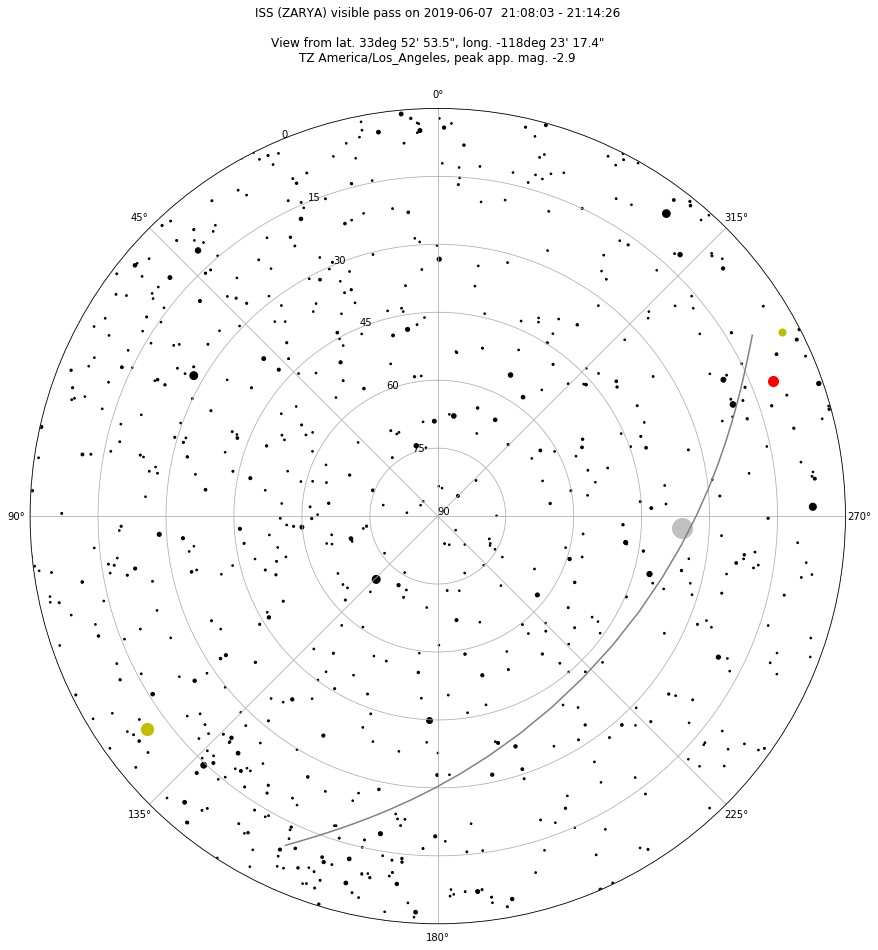

In [16]:
satplot.satellite_pass_chart(passes[26], ephemeris, bright_stars)